In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

# 1. Read Raw Data

In [2]:
url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
small_noise_url = url_root + small_noise_url_suffix
df_small_noise = pd.read_csv(small_noise_url)

daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
daily_jumpsup_url = url_root + daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(daily_jumpsup_url)

In [3]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


# 2. Visualize Data

## 2.1. Without outliers

<AxesSubplot:>

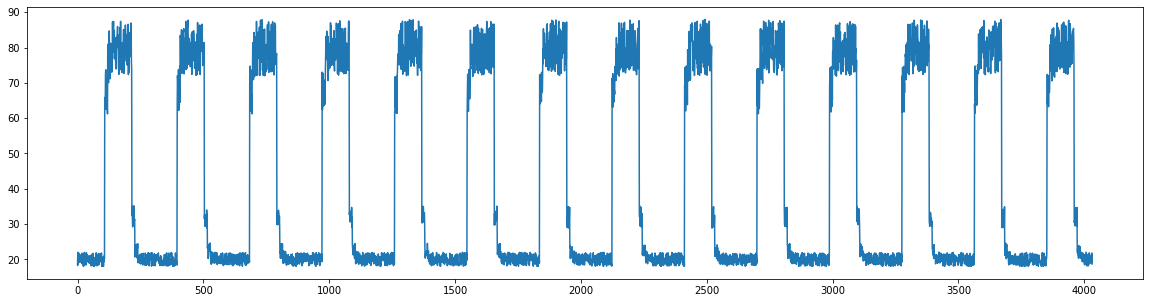

In [4]:
df_small_noise.value.plot(figsize=(20,5))

## 2.2. With outliers

<AxesSubplot:>

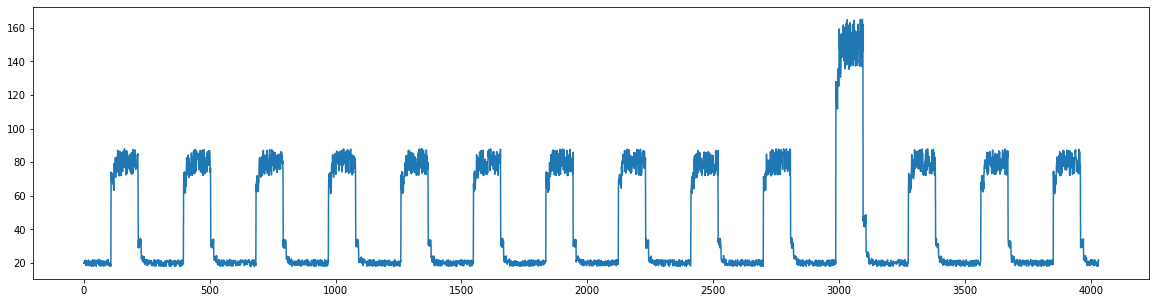

In [5]:
df_daily_jumpsup.value.plot(figsize=(20,5))

# 3. Use Statistics to Detect Anomalies

## 3.1. Median Absolute Deviation

In [6]:
mad = df_daily_jumpsup.value.mad()
anomalies_mad = df_daily_jumpsup[df_daily_jumpsup.value > mad]
anomalies_mad.describe()

,value
count,1665.000000
mean,78.837315
std,23.121490
min,29.283845
25%,73.339771
50%,78.660071
75%,83.862159
max,164.947481


## 3.2. Interquartile Range

In [7]:
q1 = df_daily_jumpsup.value.quantile(q=0.25)
q3 = df_daily_jumpsup.value.quantile(q=0.75)
iqr = q3 - q1
l_threshold = q1 - 1.5 * iqr
h_threshold = q3 + 1.5 * iqr

In [8]:
print('Q1={}, Q3={}, IQR={}, L_THR={}, H_THR={}'.format(q1, q3, iqr, l_threshold, h_threshold))

Q1=19.99138176275, Q3=76.43594258925, IQR=56.44456082650001, L_THR=-64.67545947700002, H_THR=161.10278382900003


In [9]:
anomalies_iqr = df_daily_jumpsup[df_daily_jumpsup.value > h_threshold]
anomalies_iqr.describe()

,value
count,12.000000
mean,162.888561
std,1.439290
min,161.349096
25%,161.719147
50%,162.331918
75%,164.436694
max,164.947481


## 3.3. Z-Score

In [10]:
df_daily_jumpsup_copy = df_daily_jumpsup.copy()
std = df_daily_jumpsup_copy.value.std()
mean = df_daily_jumpsup_copy.value.mean()
df_daily_jumpsup_copy['z'] = (df_daily_jumpsup_copy.value - mean) / std

<AxesSubplot:>

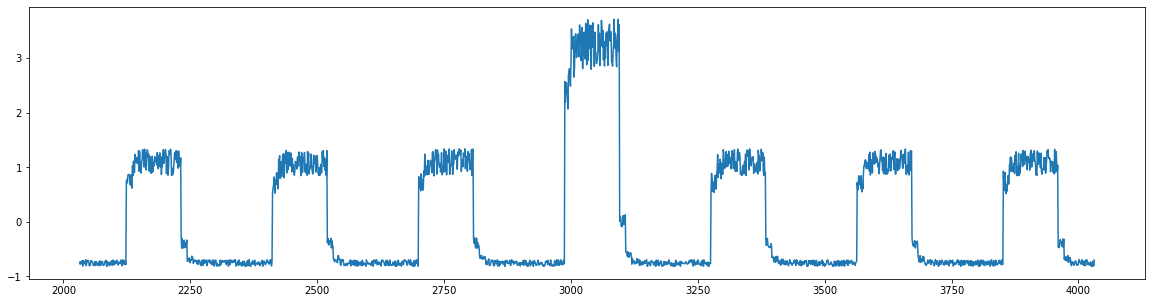

In [22]:
df_daily_jumpsup_copy.tail(2000).z.plot(figsize=(20,5))

In [12]:
z_threshold = 2.5
anomalies_z = df_daily_jumpsup_copy[df_daily_jumpsup_copy.z > z_threshold]
anomalies_z.describe()

,value,z
count,102.000000,102.000000
mean,148.747193,3.214462
std,9.533646,0.293954
min,127.261178,2.551977
25%,140.702100,2.966405
50%,149.647462,3.242220
75%,156.770953,3.461861
max,164.947481,3.713970


## 3.4. Histogram

<AxesSubplot:>

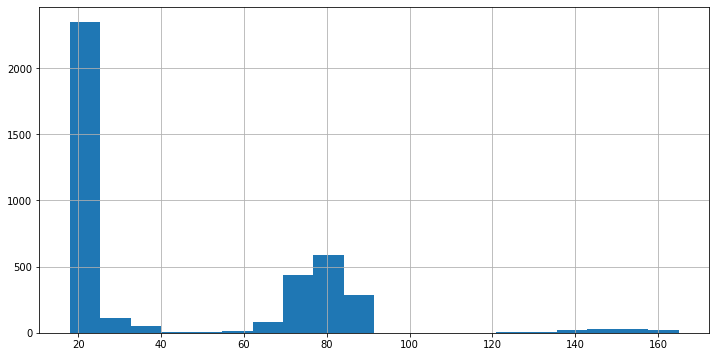

In [13]:
df_daily_jumpsup.value.hist(bins=20, figsize=(12,6))

In [14]:
anomalies_histogram = df_daily_jumpsup[df_daily_jumpsup.value > 120]
anomalies_histogram.describe()

,value
count,106.000000
mean,147.749402
std,10.638715
min,120.468468
25%,140.477747
50%,149.346186
75%,156.683030
max,164.947481


# 4. Deep-learning approach

## 4.1. Prepare Data

In [15]:
def get_value_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


# Get the `value` column from the training dataframe.
training_value = get_value_from_df(df_small_noise)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
len(training_value)

4032

## 4.2. Prepare sequences

In [16]:
TIME_STEPS = 288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)


x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


## 4.3. Build a model

In [17]:
n_steps = x_train.shape[1]
n_features = x_train.shape[2]

keras.backend.clear_session()
model = keras.Sequential(
    [
        layers.Input(shape=(n_steps, n_features)),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last',
            dilation_rate=1, activation="linear"),
        layers.LSTM(
            units=25, activation="tanh", name="lstm_1", return_sequences=False
        ),
        layers.RepeatVector(n_steps),
        layers.LSTM(
            units=25, activation="tanh", name="lstm_2", return_sequences=True
        ),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last',
            dilation_rate=1, activation="linear"),
        layers.TimeDistributed(layers.Dense(1, activation='linear'))
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 288, 32)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                5800      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 288, 25)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 288, 25)           5100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 288, 32)           12032     
_________________________________________________________________
time_distributed (TimeDistri (None, 288, 1)            33        
Total params: 23,477
Trainable params: 23,477
Non-trainable params: 0
____________________________________________________

## 4.4. Train a model

In [18]:
# history = model.fit(
#     x_train,
#     x_train,
#     epochs=200,
#     batch_size=128,
#     validation_split=0.1,
#     callbacks=[
#         keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, mode="min", restore_best_weights=True)
#     ],
# )

## 4.5. Check how well it behaved

In [19]:
# plt.plot(history.history["loss"], label="Training Loss")
# plt.plot(history.history["val_loss"], label="Validation Loss")
# plt.legend()